In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import datetime
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import os
from google.colab import drive
import datetime
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Describe Data

In [ ]:
train_data = pd.read_csv('train.csv')
print(train_data.describe())
print(train_data.info())

                id     margin1     margin2     margin3     margin4  \
count   990.000000  990.000000  990.000000  990.000000  990.000000   
mean    799.595960    0.017412    0.028539    0.031988    0.023280   
std     452.477568    0.019739    0.038855    0.025847    0.028411   
min       1.000000    0.000000    0.000000    0.000000    0.000000   
25%     415.250000    0.001953    0.001953    0.013672    0.005859   
50%     802.500000    0.009766    0.011719    0.025391    0.013672   
75%    1195.500000    0.025391    0.041016    0.044922    0.029297   
max    1584.000000    0.087891    0.205080    0.156250    0.169920   

          margin5     margin6     margin7     margin8     margin9  ...  \
count  990.000000  990.000000  990.000000  990.000000  990.000000  ...   
mean     0.014264    0.038579    0.019202    0.001083    0.007167  ...   
std      0.018390    0.052030    0.017511    0.002743    0.008933  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000000  ...   

Look For Null Values

In [ ]:
print("\nMissing values in the dataset:")
print(train_data.isnull().sum())


Missing values in the dataset:
id           0
species      0
margin1      0
margin2      0
margin3      0
            ..
texture60    0
texture61    0
texture62    0
texture63    0
texture64    0
Length: 194, dtype: int64


Remove duplicates

In [ ]:
# Check for duplicates
duplicates = train_data.duplicated()
print(f"\nNumber of duplicate rows: {duplicates.sum()}")

# Remove duplicates if any
data = train_data.drop_duplicates()
print(f"Dataset after removing duplicates: {data.shape}")


Number of duplicate rows: 0
Dataset after removing duplicates: (990, 194)


Load Data & Images

In [ ]:
# Path to the image folder
image_folder = '/content/drive/MyDrive/Leaf Classification Images/images'

# Function to load and preprocess images
def load_image(img_path, target_size=(192, 192)):
    img_full_path = os.path.join(image_folder, str(img_path) + '.jpg')  # Full path to the image
    img = image.load_img(img_full_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array


image_ids = train_data['id']
labels = train_data['species']
tabular_features = train_data.drop(columns=['id', 'species'])
#apply correlation analysis and remove duplicate features
correlation_matrix = tabular_features.corr()
threshold=0.85
to_drop=set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)
tabular_features = tabular_features.drop(columns=to_drop)
print(f"Dropped Features: {to_drop}")

# Normalize tabular features
scaler = StandardScaler()
tabular_features = scaler.fit_transform(tabular_features)

# 3. Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
tabular_features = pca.fit_transform(tabular_features)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split data
X_train_img, X_test_img, y_train, y_test = train_test_split(image_ids, labels_encoded, test_size=0.2, random_state=42)
X_train_tabular, X_test_tabular = train_test_split(tabular_features, test_size=0.2, random_state=42)

# Load and preprocess images for training and testing
X_train_images = np.array([load_image(img) for img in X_train_img])
X_test_images = np.array([load_image(img) for img in X_test_img])

Dropped Features: {'shape48', 'shape34', 'shape37', 'shape10', 'shape53', 'shape6', 'shape52', 'shape60', 'shape55', 'shape57', 'shape25', 'shape46', 'shape13', 'shape28', 'shape40', 'shape15', 'shape14', 'shape4', 'shape44', 'shape18', 'shape61', 'shape51', 'shape58', 'shape12', 'shape16', 'shape9', 'shape41', 'shape62', 'shape56', 'shape45', 'shape59', 'shape47', 'shape43', 'shape50', 'shape11', 'shape27', 'shape64', 'shape30', 'shape7', 'shape29', 'shape31', 'shape21', 'shape49', 'margin39', 'shape5', 'shape17', 'shape3', 'shape19', 'shape22', 'shape23', 'shape32', 'shape33', 'shape8', 'shape39', 'shape35', 'margin49', 'shape2', 'shape38', 'shape63', 'shape24', 'shape36', 'shape20', 'shape26', 'shape54', 'shape42'}


Display Some Images

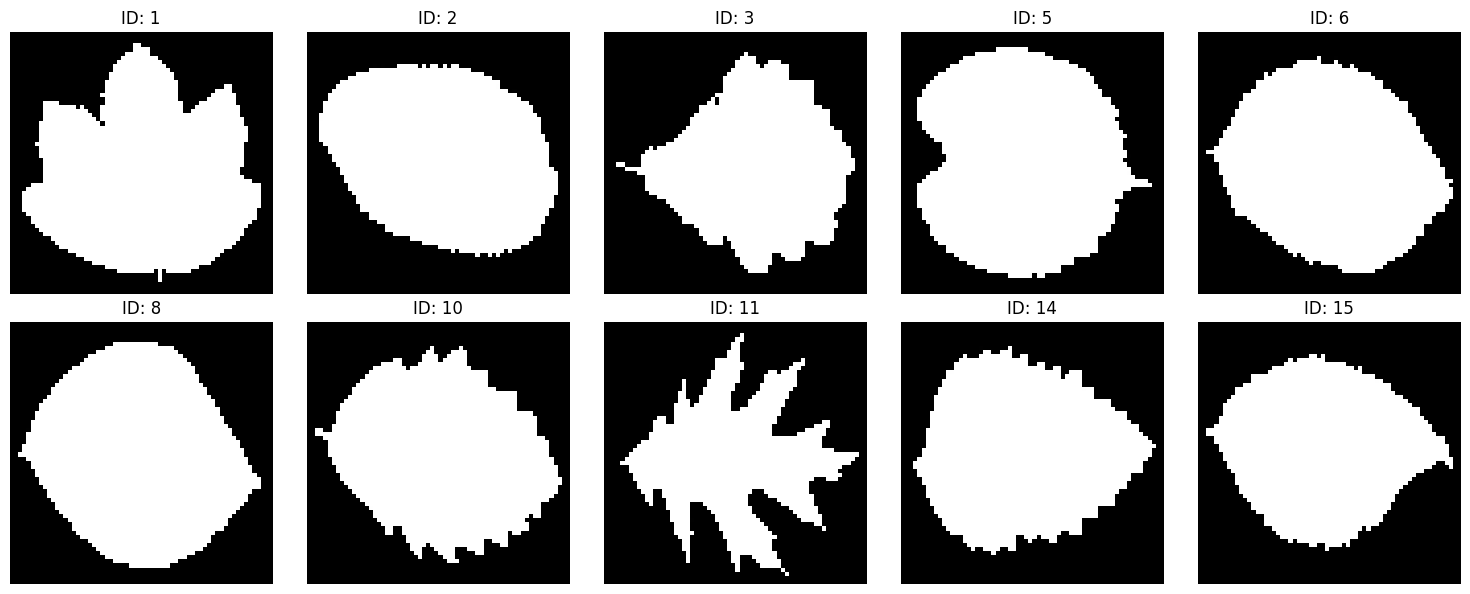

In [ ]:
# Function to load and display an image
def display_images(image_ids, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, img_id in enumerate(image_ids[:rows * cols]):
        img_path = os.path.join(image_folder, str(img_id) + '.jpg')
        img = image.load_img(img_path, target_size=(64, 64))
        axes[i // cols, i % cols].imshow(img)
        axes[i // cols, i % cols].axis('off')
        axes[i // cols, i % cols].set_title(f'ID: {img_id}')
    plt.tight_layout()
    plt.show()

# Display the first 10 images
display_images(data['id'])

Pixels Histogram

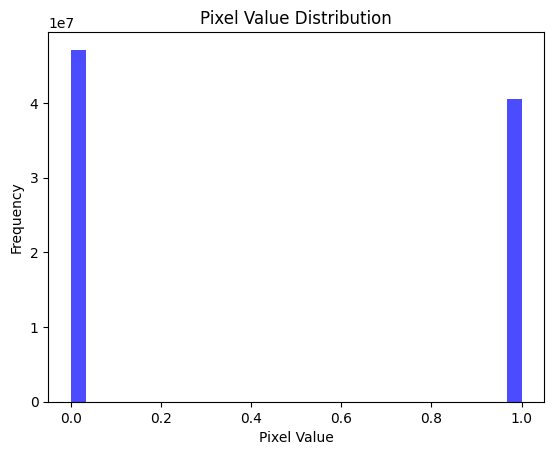

In [ ]:
# Flatten all images to a 1D array
pixel_values = np.array(X_train_images).flatten()

# Plot histogram
plt.hist(pixel_values, bins=30, color='blue', alpha=0.7)
plt.title("Pixel Value Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

CNN Architecture

In [ ]:
def training(X_train_images, X_train_tabular, y_train, X_test_images, X_test_tabular, y_test, epochs, batch_size, learning_rate, dropout, optimizer_name, l2_factor):
    # Define the CNN model for image input
    image_input = Input(shape=(192, 192, 3))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)

    # Define the Dense model for tabular input
    tabular_input = Input(shape=(X_train_tabular.shape[1],))
    y = Dense(128, activation='relu')(tabular_input)
    y = Dropout(dropout)(y)
    y = Dense(64, activation='relu')(y)
    y = Dropout(dropout)(y)

    # Combine image and tabular models
    combined = Concatenate()([x, y])
    z = Dense(512, activation='relu')(combined)
    z = Dropout(dropout)(z)
    z = Dense(256, activation='relu')(z)
    output = Dense(len(np.unique(y_train)), activation='softmax')(z)

    # Create the model
    model = Model(inputs=[image_input, tabular_input], outputs=output)

    # Define optimizer
    optimizers_dict = {
        'adam': Adam(learning_rate=learning_rate, weight_decay=l2_factor),
        'sgd': SGD(learning_rate=learning_rate, weight_decay=l2_factor),
        'rmsprop': RMSprop(learning_rate=learning_rate, weight_decay=l2_factor),
    }
    optimizer = optimizers_dict.get(optimizer_name.lower())
    if not optimizer:
        raise ValueError(f"Unknown optimizer '{optimizer_name}'. Available: {list(optimizers_dict.keys())}")

    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Callbacks
    checkpoint_callback = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    log_dir = f"logs/fit/optimizer_{optimizer_name}_l2_{l2_factor}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Train the model
    history = model.fit(
        [X_train_images, X_train_tabular],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[checkpoint_callback, tensorboard_callback]
    )

    # Evaluate the model
    train_loss, train_acc = model.evaluate([X_train_images, X_train_tabular], y_train, verbose=0)
    test_loss, test_acc = model.evaluate([X_test_images, X_test_tabular], y_test, verbose=0)
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")


def training2(X_train_images, X_train_tabular, y_train, X_test_images, X_test_tabular, y_test, epochs, batch_size, learning_rate, dropout, optimizer_name, l2_factor):
    # Define the CNN model for image input
    image_input = Input(shape=(192, 192, 3))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)

    # Define the Dense model for tabular input
    tabular_input = Input(shape=(X_train_tabular.shape[1],))
    y = Dense(128, activation='relu')(tabular_input)
    y = Dropout(dropout)(y)
    y = Dense(64, activation='relu')(y)
    y = Dropout(dropout)(y)

    # Combine image and tabular models
    combined = Concatenate()([x, y])
    z = Dense(512, activation='relu')(combined)
    z = Dropout(dropout)(z)
    z = Dense(256, activation='relu')(z)
    output = Dense(len(np.unique(y_train)), activation='softmax')(z)

    # Create the model
    model = Model(inputs=[image_input, tabular_input], outputs=output)

    # Define optimizer
    optimizers_dict = {
        'adam': Adam(learning_rate=learning_rate, weight_decay=l2_factor),
        'sgd': SGD(learning_rate=learning_rate, weight_decay=l2_factor),
        'rmsprop': RMSprop(learning_rate=learning_rate, weight_decay=l2_factor),
    }
    optimizer = optimizers_dict.get(optimizer_name.lower())
    if not optimizer:
        raise ValueError(f"Unknown optimizer '{optimizer_name}'. Available: {list(optimizers_dict.keys())}")

    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Callbacks
    checkpoint_callback = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    log_dir = f"logs/fit/optimizer_{optimizer_name}_l2_{l2_factor}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Train the model
    history = model.fit(
        [X_train_images, X_train_tabular],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[checkpoint_callback, tensorboard_callback]
    )

    # Evaluate the model
    train_loss, train_acc = model.evaluate([X_train_images, X_train_tabular], y_train, verbose=0)
    test_loss, test_acc = model.evaluate([X_test_images, X_test_tabular], y_test, verbose=0)
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")





def training3(X_train_images, X_train_tabular, y_train, X_test_images, X_test_tabular, y_test, epochs, batch_size, learning_rate, dropout, optimizer_name, l2_factor):
    # Define the CNN model for image input
    image_input = Input(shape=(192, 192, 3))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)

    # Define the Dense model for tabular input
    tabular_input = Input(shape=(X_train_tabular.shape[1],))
    y = Dense(128, activation='relu')(tabular_input)
    y = Dropout(dropout)(y)
    y = Dense(64, activation='relu')(y)
    y = Dropout(dropout)(y)

    # Combine image and tabular models
    combined = Concatenate()([x, y])
    z = Dense(512, activation='relu')(combined)
    z = Dropout(dropout)(z)
    z = Dense(256, activation='relu')(z)
    output = Dense(len(np.unique(y_train)), activation='softmax')(z)

    # Create the model
    model = Model(inputs=[image_input, tabular_input], outputs=output)

    # Define optimizer
    optimizers_dict = {
        'adam': Adam(learning_rate=learning_rate, weight_decay=l2_factor),
        'sgd': SGD(learning_rate=learning_rate, weight_decay=l2_factor),
        'rmsprop': RMSprop(learning_rate=learning_rate, weight_decay=l2_factor),
    }
    optimizer = optimizers_dict.get(optimizer_name.lower())
    if not optimizer:
        raise ValueError(f"Unknown optimizer '{optimizer_name}'. Available: {list(optimizers_dict.keys())}")

    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Callbacks
    checkpoint_callback = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    log_dir = f"logs/fit/optimizer_{optimizer_name}_l2_{l2_factor}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Train the model
    history = model.fit(
        [X_train_images, X_train_tabular],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[checkpoint_callback, tensorboard_callback]
    )

    # Evaluate the model
    train_loss, train_acc = model.evaluate([X_train_images, X_train_tabular], y_train, verbose=0)
    test_loss, test_acc = model.evaluate([X_test_images, X_test_tabular], y_test, verbose=0)
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")







Try Different Learning Rates

In [ ]:
# List of learning rates to experiment with
learning_rates = [0.0001, 0.001, 0.01]

# Loop through each learning rate and train the model
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    training2(X_train_images, X_train_tabular, y_train, X_test_images, X_test_tabular, y_test, epochs=55, batch_size=32, learning_rate=lr,dropout=0.2, optimizer_name="adam", l2_factor=0.0)


Training with learning rate: 0.0001


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_30[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 192, 192, 64)   │            256 │ conv2d_47[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_45          │ (None, 96, 96, 64)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_45[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_46    │ (None, 96, 96, 128)    │            512 │ conv2d_48[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_46          │ (None, 48, 48, 128)    │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_46[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_31            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_47    │ (None, 48, 48, 256)    │          1,024 │ conv2d_49[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_75 (Dense)          │ (None, 128)            │          9,472 │ input_layer_31[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_47          │ (None, 24, 24, 256)    │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_61 (Dropout)      │ (None, 128)            │              0 │ dense_75[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_47[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_76 (Dense)          │ (None, 64)             │          8,256 │ dropout_61[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.0195 - loss: 4.6423
Epoch 1: val_accuracy improved from -inf to 0.01258, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - accuracy: 0.0194 - loss: 4.6421 - val_accuracy: 0.0126 - val_loss: 4.5798
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0300 - loss: 4.5197
Epoch 2: val_accuracy did not improve from 0.01258
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.0299 - loss: 4.5204 - val_accuracy: 0.0126 - val_loss: 4.5665
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.0562 - loss: 4.4469
Epoch 3: val_accuracy did not improve from 0.01258
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.0561 - loss: 4.4472 - val_accuracy: 0.0063 - val_loss: 4.5540
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0650 - loss: 4.3780
Epoch 4: val_accuracy did not improve from 0.01258
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.0642 - loss: 

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_32[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 192, 192, 64)   │            256 │ conv2d_50[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_48          │ (None, 96, 96, 64)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_48[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_49    │ (None, 96, 96, 128)    │            512 │ conv2d_51[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_49          │ (None, 48, 48, 128)    │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_49[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_33            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_50    │ (None, 48, 48, 256)    │          1,024 │ conv2d_52[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_80 (Dense)          │ (None, 128)            │          9,472 │ input_layer_33[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_50          │ (None, 24, 24, 256)    │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_65 (Dropout)      │ (None, 128)            │              0 │ dense_80[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_50[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_81 (Dense)          │ (None, 64)             │          8,256 │ dropout_65[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.0152 - loss: 4.6093
Epoch 1: val_accuracy improved from -inf to 0.00629, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 475ms/step - accuracy: 0.0156 - loss: 4.6059 - val_accuracy: 0.0063 - val_loss: 4.5572
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0994 - loss: 4.0763
Epoch 2: val_accuracy improved from 0.00629 to 0.01258, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.1005 - loss: 4.0690 - val_accuracy: 0.0126 - val_loss: 4.9215
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2631 - loss: 3.2222
Epoch 3: val_accuracy improved from 0.01258 to 0.05660, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.2654 - loss: 3.2107 - val_accuracy: 0.0566 - val_loss: 5.5615
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4963 - loss: 2.1270
Epoch 4: val_accuracy improved from 0.05660

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_34[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_51    │ (None, 192, 192, 64)   │            256 │ conv2d_53[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_51          │ (None, 96, 96, 64)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_51[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_52    │ (None, 96, 96, 128)    │            512 │ conv2d_54[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_52          │ (None, 48, 48, 128)    │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_52[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_35            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_53    │ (None, 48, 48, 256)    │          1,024 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_85 (Dense)          │ (None, 128)            │          9,472 │ input_layer_35[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_53          │ (None, 24, 24, 256)    │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_69 (Dropout)      │ (None, 128)            │              0 │ dense_85[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_53[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_86 (Dense)          │ (None, 64)             │          8,256 │ dropout_69[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.0143 - loss: 4.8391
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 401ms/step - accuracy: 0.0150 - loss: 4.8269 - val_accuracy: 0.0000e+00 - val_loss: 55.1742
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0938 - loss: 3.8841
Epoch 2: val_accuracy improved from 0.00000 to 0.00629, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.0955 - loss: 3.8745 - val_accuracy: 0.0063 - val_loss: 35.0630
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2730 - loss: 2.8032
Epoch 3: val_accuracy improved from 0.00629 to 0.01258, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.2734 - loss: 2.7996 - val_accuracy: 0.0126 - val_loss: 33.9470
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3377 - loss: 2.5044
Epoch 4: val_accuracy improved from 

Try Different Batch Sizes

In [ ]:
# List of batch sizes to experiment with
batch_sizes = [16, 32, 64]

# Loop through each batch size and train the model
for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    training2(X_train_images, X_train_tabular, y_train, X_test_images, X_test_tabular, y_test, epochs=55, batch_size=batch_size, learning_rate=0.0001,dropout=0.2, optimizer_name="adam", l2_factor=0.0)


Training with batch size: 16


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_36[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_54    │ (None, 192, 192, 64)   │            256 │ conv2d_56[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_54          │ (None, 96, 96, 64)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_54[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_55    │ (None, 96, 96, 128)    │            512 │ conv2d_57[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_55          │ (None, 48, 48, 128)    │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_55[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_37            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 48, 48, 256)    │          1,024 │ conv2d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_90 (Dense)          │ (None, 128)            │          9,472 │ input_layer_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_56          │ (None, 24, 24, 256)    │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_73 (Dropout)      │ (None, 128)            │              0 │ dense_90[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_56[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_91 (Dense)          │ (None, 64)             │          8,256 │ dropout_73[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.0091 - loss: 4.6187
Epoch 1: val_accuracy improved from -inf to 0.00629, saving model to best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 385ms/step - accuracy: 0.0093 - loss: 4.6187 - val_accuracy: 0.0063 - val_loss: 4.5898
Epoch 2/55
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0329 - loss: 4.5127
Epoch 2: val_accuracy improved from 0.00629 to 0.01258, saving model to best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0331 - loss: 4.5120 - val_accuracy: 0.0126 - val_loss: 4.5817
Epoch 3/55
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0494 - loss: 4.3965
Epoch 3: val_accuracy did not improve from 0.01258
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.0493 - loss: 4.3966 - val_accuracy: 0.0126 - val_loss: 4.5648
Epoch 4/55
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0473 - loss: 4.3428
Epoch 4: val_accuracy improved from 0.01258 to 0.01887, saving model to best_model

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_57    │ (None, 192, 192, 64)   │            256 │ conv2d_59[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_57          │ (None, 96, 96, 64)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_57[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_58    │ (None, 96, 96, 128)    │            512 │ conv2d_60[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_58          │ (None, 48, 48, 128)    │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_58[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_39            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_59    │ (None, 48, 48, 256)    │          1,024 │ conv2d_61[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_95 (Dense)          │ (None, 128)            │          9,472 │ input_layer_39[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_59          │ (None, 24, 24, 256)    │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_77 (Dropout)      │ (None, 128)            │              0 │ dense_95[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_59[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_96 (Dense)          │ (None, 64)             │          8,256 │ dropout_77[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.0140 - loss: 4.6388
Epoch 1: val_accuracy improved from -inf to 0.02516, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 471ms/step - accuracy: 0.0143 - loss: 4.6385 - val_accuracy: 0.0252 - val_loss: 4.5810
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0354 - loss: 4.5034
Epoch 2: val_accuracy did not improve from 0.02516
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.0350 - loss: 4.5048 - val_accuracy: 0.0189 - val_loss: 4.5718
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0374 - loss: 4.4655
Epoch 3: val_accuracy did not improve from 0.02516
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.0378 - loss: 4.4652 - val_accuracy: 0.0189 - val_loss: 4.5636
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0786 - loss: 4.3865
Epoch 4: val_accuracy improved from 0.02516 to 0.03145, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_60    │ (None, 192, 192, 64)   │            256 │ conv2d_62[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_60          │ (None, 96, 96, 64)     │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_60[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_61    │ (None, 96, 96, 128)    │            512 │ conv2d_63[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_61          │ (None, 48, 48, 128)    │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_61[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_41            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_62    │ (None, 48, 48, 256)    │          1,024 │ conv2d_64[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_100 (Dense)         │ (None, 128)            │          9,472 │ input_layer_41[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_62          │ (None, 24, 24, 256)    │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_81 (Dropout)      │ (None, 128)            │              0 │ dense_100[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_62[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_101 (Dense)         │ (None, 64)             │          8,256 │ dropout_81[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0026 - loss: 4.6524   
Epoch 1: val_accuracy improved from -inf to 0.01887, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.0026 - loss: 4.6515 - val_accuracy: 0.0189 - val_loss: 4.5898
Epoch 2/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.0083 - loss: 4.5748
Epoch 2: val_accuracy did not improve from 0.01887
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.0090 - loss: 4.5741 - val_accuracy: 0.0126 - val_loss: 4.5810
Epoch 3/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.0212 - loss: 4.5265
Epoch 3: val_accuracy did not improve from 0.01887
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.0224 - loss: 4.5251 - val_accuracy: 0.0189 - val_loss: 4.5717
Epoch 4/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.0202 - loss: 4.4812
Epoch 4: val_accuracy did not improve from 0.01887
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.0208 - loss: 

In [ ]:
# List of epoch counts to experiment with
epochs_list = [30, 50, 70]

# Loop through each number of epochs and train the model
for epochs in epochs_list:
    print(f"Training with epochs: {epochs}")
    training2(X_train_images, X_train_tabular, y_train, X_test_images, X_test_tabular, y_test, epochs=epochs, batch_size=32, learning_rate=0.0001,dropout=0.2, optimizer_name="adam", l2_factor=0.0)


Training with epochs: 30


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_42[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_63    │ (None, 192, 192, 64)   │            256 │ conv2d_65[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_63          │ (None, 96, 96, 64)     │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_63[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_64    │ (None, 96, 96, 128)    │            512 │ conv2d_66[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_64          │ (None, 48, 48, 128)    │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_64[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_43            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_65    │ (None, 48, 48, 256)    │          1,024 │ conv2d_67[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_105 (Dense)         │ (None, 128)            │          9,472 │ input_layer_43[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_65          │ (None, 24, 24, 256)    │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_85 (Dropout)      │ (None, 128)            │              0 │ dense_105[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_65[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_106 (Dense)         │ (None, 64)             │          8,256 │ dropout_85[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.0170 - loss: 4.6541
Epoch 1: val_accuracy improved from -inf to 0.00629, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 379ms/step - accuracy: 0.0171 - loss: 4.6532 - val_accuracy: 0.0063 - val_loss: 4.5792
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0393 - loss: 4.5067
Epoch 2: val_accuracy did not improve from 0.00629
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.0390 - loss: 4.5072 - val_accuracy: 0.0063 - val_loss: 4.5637
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0352 - loss: 4.4501
Epoch 3: val_accuracy did not improve from 0.00629
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.0348 - loss: 4.4503 - val_accuracy: 0.0063 - val_loss: 4.5529
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0539 - loss: 4.3693
Epoch 4: val_accuracy did not improve from 0.00629
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.0538 - loss:

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_66    │ (None, 192, 192, 64)   │            256 │ conv2d_68[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_66          │ (None, 96, 96, 64)     │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_66[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_67    │ (None, 96, 96, 128)    │            512 │ conv2d_69[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_67          │ (None, 48, 48, 128)    │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_67[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_45            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_68    │ (None, 48, 48, 256)    │          1,024 │ conv2d_70[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_110 (Dense)         │ (None, 128)            │          9,472 │ input_layer_45[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_68          │ (None, 24, 24, 256)    │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_89 (Dropout)      │ (None, 128)            │              0 │ dense_110[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_68[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_111 (Dense)         │ (None, 64)             │          8,256 │ dropout_89[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.0149 - loss: 4.6551
Epoch 1: val_accuracy improved from -inf to 0.01887, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 463ms/step - accuracy: 0.0151 - loss: 4.6540 - val_accuracy: 0.0189 - val_loss: 4.5762
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0410 - loss: 4.5132
Epoch 2: val_accuracy did not improve from 0.01887
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.0407 - loss: 4.5129 - val_accuracy: 0.0126 - val_loss: 4.5598
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0429 - loss: 4.4744
Epoch 3: val_accuracy did not improve from 0.01887
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.0431 - loss: 4.4735 - val_accuracy: 0.0063 - val_loss: 4.5446
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0483 - loss: 4.4049
Epoch 4: val_accuracy did not improve from 0.01887
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.0489 - loss: 

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_46[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_69    │ (None, 192, 192, 64)   │            256 │ conv2d_71[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_69          │ (None, 96, 96, 64)     │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_69[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_70    │ (None, 96, 96, 128)    │            512 │ conv2d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_70          │ (None, 48, 48, 128)    │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_70[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_47            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_71    │ (None, 48, 48, 256)    │          1,024 │ conv2d_73[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_115 (Dense)         │ (None, 128)            │          9,472 │ input_layer_47[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_71          │ (None, 24, 24, 256)    │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_93 (Dropout)      │ (None, 128)            │              0 │ dense_115[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_71[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_116 (Dense)         │ (None, 64)             │          8,256 │ dropout_93[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.0010 - loss: 4.6821   
Epoch 1: val_accuracy improved from -inf to 0.01258, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - accuracy: 0.0011 - loss: 4.6806 - val_accuracy: 0.0126 - val_loss: 4.6024
Epoch 2/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0048 - loss: 4.5693
Epoch 2: val_accuracy improved from 0.01258 to 0.01887, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.0051 - loss: 4.5681 - val_accuracy: 0.0189 - val_loss: 4.5877
Epoch 3/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0339 - loss: 4.4684
Epoch 3: val_accuracy did not improve from 0.01887
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.0339 - loss: 4.4682 - val_accuracy: 0.0126 - val_loss: 4.5715
Epoch 4/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0416 - loss: 4.3963
Epoch 4: val_accuracy improved from 0.01887 to 0.02516, saving model to best_m

Try Different dropouts

In [ ]:
dropout_list = [0.2 , 0.4 , 0.5]

for dropout in dropout_list:
    print(f"Training with dropout: {dropout}")x
    training2(X_train_images, X_train_tabular, y_train, X_test_images, X_test_tabular, y_test, epochs=55, batch_size=32, learning_rate=0.0001,dropout=dropout, optimizer_name="adam", l2_factor=0.0)

Training with dropout: 0.2


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_48[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 192, 192, 64)   │            256 │ conv2d_74[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_72          │ (None, 96, 96, 64)     │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_72[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 96, 96, 128)    │            512 │ conv2d_75[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_73          │ (None, 48, 48, 128)    │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_73[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_49            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 48, 48, 256)    │          1,024 │ conv2d_76[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_120 (Dense)         │ (None, 128)            │          9,472 │ input_layer_49[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_74          │ (None, 24, 24, 256)    │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_97 (Dropout)      │ (None, 128)            │              0 │ dense_120[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_74[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_121 (Dense)         │ (None, 64)             │          8,256 │ dropout_97[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.0070 - loss: 4.6098
Epoch 1: val_accuracy improved from -inf to 0.01258, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 472ms/step - accuracy: 0.0072 - loss: 4.6097 - val_accuracy: 0.0126 - val_loss: 4.5747
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0335 - loss: 4.5254
Epoch 2: val_accuracy improved from 0.01258 to 0.01887, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.0335 - loss: 4.5249 - val_accuracy: 0.0189 - val_loss: 4.5581
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0359 - loss: 4.4632
Epoch 3: val_accuracy improved from 0.01887 to 0.03774, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.0360 - loss: 4.4625 - val_accuracy: 0.0377 - val_loss: 4.5403
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0512 - loss: 4.3983
Epoch 4: val_accuracy improved from 0.03774

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_50[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_75    │ (None, 192, 192, 64)   │            256 │ conv2d_77[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_75          │ (None, 96, 96, 64)     │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_75[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_76    │ (None, 96, 96, 128)    │            512 │ conv2d_78[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_76          │ (None, 48, 48, 128)    │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_76[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_51            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_77    │ (None, 48, 48, 256)    │          1,024 │ conv2d_79[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_125 (Dense)         │ (None, 128)            │          9,472 │ input_layer_51[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_77          │ (None, 24, 24, 256)    │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_101 (Dropout)     │ (None, 128)            │              0 │ dense_125[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_77[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_126 (Dense)         │ (None, 64)             │          8,256 │ dropout_101[0][0]      │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.0053 - loss: 4.7256
Epoch 1: val_accuracy improved from -inf to 0.01258, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 436ms/step - accuracy: 0.0054 - loss: 4.7247 - val_accuracy: 0.0126 - val_loss: 4.6181
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0141 - loss: 4.6370
Epoch 2: val_accuracy did not improve from 0.01258
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.0141 - loss: 4.6363 - val_accuracy: 0.0126 - val_loss: 4.6085
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0336 - loss: 4.5639
Epoch 3: val_accuracy did not improve from 0.01258
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.0335 - loss: 4.5641 - val_accuracy: 0.0000e+00 - val_loss: 4.6011
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0194 - loss: 4.5608
Epoch 4: val_accuracy did not improve from 0.01258
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.0196 - lo

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_52            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_52[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_78    │ (None, 192, 192, 64)   │            256 │ conv2d_80[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_78          │ (None, 96, 96, 64)     │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_78[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_79    │ (None, 96, 96, 128)    │            512 │ conv2d_81[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_79          │ (None, 48, 48, 128)    │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_82 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_79[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_53            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_80    │ (None, 48, 48, 256)    │          1,024 │ conv2d_82[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_130 (Dense)         │ (None, 128)            │          9,472 │ input_layer_53[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_80          │ (None, 24, 24, 256)    │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_105 (Dropout)     │ (None, 128)            │              0 │ dense_130[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_80[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_131 (Dense)         │ (None, 64)             │          8,256 │ dropout_105[0][0]      │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.0025 - loss: 4.8266
Epoch 1: val_accuracy improved from -inf to 0.00629, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 504ms/step - accuracy: 0.0026 - loss: 4.8257 - val_accuracy: 0.0063 - val_loss: 4.5823
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0147 - loss: 4.7063
Epoch 2: val_accuracy did not improve from 0.00629
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.0144 - loss: 4.7063 - val_accuracy: 0.0063 - val_loss: 4.5812
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0032 - loss: 4.6383
Epoch 3: val_accuracy improved from 0.00629 to 0.01887, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.0033 - loss: 4.6395 - val_accuracy: 0.0189 - val_loss: 4.5820
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0208 - loss: 4.6323
Epoch 4: val_accuracy did not improve from 0.01887
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 

Try Different Optimizers

In [ ]:
# List of optimizers to experiment with
optimizers = ['adam', 'sgd', 'rmsprop']

# Loop through each optimizer and train the model
for optimizer in optimizers:
    print(f"Training with optimizer: {optimizer}")
    training2(X_train_images, X_train_tabular, y_train, X_test_images, X_test_tabular, y_test, epochs=55, batch_size=32, learning_rate=0.0001, dropout=0.2, optimizer_name=optimizer, l2_factor=0.0)

Training with optimizer: adam


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 192, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 192, 192, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 192, 192, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 96, 96, 64)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 96, 96, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 48, 48, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 48, 48, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 24, 24, 256)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 256)            │              0 │ max_pooling2d_2[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)    

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.0242 - loss: 4.6572
Epoch 1: val_accuracy improved from -inf to 0.00629, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.0240 - loss: 4.6564 - val_accuracy: 0.0063 - val_loss: 4.6276
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0194 - loss: 4.5201
Epoch 2: val_accuracy did not improve from 0.00629
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.0194 - loss: 4.5202 - val_accuracy: 0.0063 - val_loss: 4.6112
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0332 - loss: 4.4974
Epoch 3: val_accuracy improved from 0.00629 to 0.01258, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.0330 - loss: 4.4969 - val_accuracy: 0.0126 - val_loss: 4.6024
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0441 - loss: 4.4403
Epoch 4: val_accuracy improved from 0.01258 to 0.02516, saving model to best_model.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 192, 192, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 192, 192, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 96, 96, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 96, 96, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 48, 48, 128)    │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 48, 48, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │          9,472 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 24, 24, 256)    │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_5[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          8,256 │ dropout_5[0][0]        │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.0055 - loss: 4.6942
Epoch 1: val_accuracy improved from -inf to 0.00629, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 471ms/step - accuracy: 0.0056 - loss: 4.6942 - val_accuracy: 0.0063 - val_loss: 4.6360
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0065 - loss: 4.6890
Epoch 2: val_accuracy did not improve from 0.00629
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.0064 - loss: 4.6886 - val_accuracy: 0.0063 - val_loss: 4.6352
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0125 - loss: 4.6743
Epoch 3: val_accuracy improved from 0.00629 to 0.01887, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.0124 - loss: 4.6740 - val_accuracy: 0.0189 - val_loss: 4.6368
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0027 - loss: 4.6853
Epoch 4: val_accuracy did not improve from 0.01887
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 192, 192, 64)   │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 192, 192, 64)   │            256 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 96, 96, 64)     │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 96, 96, 128)    │            512 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 48, 48, 128)    │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 48, 48, 256)    │          1,024 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │          9,472 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 24, 24, 256)    │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128)            │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_8[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 64)             │          8,256 │ dropout_9[0][0]        │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.0128 - loss: 4.6226
Epoch 1: val_accuracy improved from -inf to 0.01258, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 406ms/step - accuracy: 0.0129 - loss: 4.6215 - val_accuracy: 0.0126 - val_loss: 4.5711
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.0110 - loss: 4.5265
Epoch 2: val_accuracy improved from 0.01258 to 0.02516, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.0110 - loss: 4.5260 - val_accuracy: 0.0252 - val_loss: 4.5607
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0293 - loss: 4.4792
Epoch 3: val_accuracy did not improve from 0.02516
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.0297 - loss: 4.4783 - val_accuracy: 0.0252 - val_loss: 4.5540
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0846 - loss: 4.3992
Epoch 4: val_accuracy did not improve from 0.02516
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 

Try different L2 Regularization Factors

In [ ]:


# List of L2 regularization factors to experiment with
l2_factors = [0.001, 0.01, 0.0001]

# Loop through each L2 factor and train the model
for l2_factor in l2_factors:
    print(f"Training with L2 regularization factor: {l2_factor}")

    training2(
        X_train_images, X_train_tabular, y_train,
        X_test_images, X_test_tabular, y_test,
        epochs=55, batch_size=32, learning_rate=0.0001,
        dropout=0.2, optimizer_name='adam', l2_factor=l2_factor
    )


Training with L2 regularization factor: 0.001


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 192, 192, 64)   │          1,792 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 192, 192, 64)   │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 96, 96, 64)     │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 96, 96, 128)    │            512 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 48, 48, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 48, 48, 256)    │          1,024 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 128)            │          9,472 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 24, 24, 256)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 128)            │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_11[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 64)             │          8,256 │ dropout_13[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.0115 - loss: 4.6616
Epoch 1: val_accuracy improved from -inf to 0.01887, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 492ms/step - accuracy: 0.0114 - loss: 4.6601 - val_accuracy: 0.0189 - val_loss: 4.5925
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0254 - loss: 4.5339
Epoch 2: val_accuracy did not improve from 0.01887
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.0257 - loss: 4.5335 - val_accuracy: 0.0126 - val_loss: 4.5821
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0331 - loss: 4.4909
Epoch 3: val_accuracy did not improve from 0.01887
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.0339 - loss: 4.4899 - val_accuracy: 0.0063 - val_loss: 4.5739
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0695 - loss: 4.3960
Epoch 4: val_accuracy did not improve from 0.01887
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.0694 - loss: 

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 192, 192, 64)   │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 96, 96, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 96, 96, 128)    │            512 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 48, 48, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 48, 48, 256)    │          1,024 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 128)            │          9,472 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 24, 24, 256)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 128)            │              0 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_14[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 64)             │          8,256 │ dropout_17[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.0099 - loss: 4.6466
Epoch 1: val_accuracy improved from -inf to 0.01258, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 561ms/step - accuracy: 0.0102 - loss: 4.6457 - val_accuracy: 0.0126 - val_loss: 4.5890
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0228 - loss: 4.5589
Epoch 2: val_accuracy did not improve from 0.01258
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.0232 - loss: 4.5579 - val_accuracy: 0.0126 - val_loss: 4.5741
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0256 - loss: 4.4819
Epoch 3: val_accuracy improved from 0.01258 to 0.02516, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.0258 - loss: 4.4810 - val_accuracy: 0.0252 - val_loss: 4.5651
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0453 - loss: 4.4202
Epoch 4: val_accuracy improved from 0.02516 to 0.03145, saving model to best_mode

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 192, 192, 64)   │            256 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 96, 96, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 96, 96, 128)    │            512 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 48, 48, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 48, 48, 256)    │          1,024 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 128)            │          9,472 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 24, 24, 256)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 128)            │              0 │ dense_25[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_17[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 64)             │          8,256 │ dropout_21[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.0125 - loss: 4.6709
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 560ms/step - accuracy: 0.0126 - loss: 4.6699 - val_accuracy: 0.0000e+00 - val_loss: 4.6002
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0219 - loss: 4.5584
Epoch 2: val_accuracy did not improve from 0.00000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.0222 - loss: 4.5573 - val_accuracy: 0.0000e+00 - val_loss: 4.5894
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0431 - loss: 4.4819
Epoch 3: val_accuracy improved from 0.00000 to 0.00629, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.0434 - loss: 4.4807 - val_accuracy: 0.0063 - val_loss: 4.5778
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0622 - loss: 4.4195
Epoch 4: val_accuracy did not improve from 0.00629
20/20 ━━━━━━━━━━━━━━━━

Try Different number of layers

In [ ]:

    training(
        X_train_images, X_train_tabular, y_train,
        X_test_images, X_test_tabular, y_test,
        epochs=55, batch_size=32, learning_rate=0.0001,
        dropout=0.2, optimizer_name='adam', l2_factor=0.0
    )

    training2(
        X_train_images, X_train_tabular, y_train,
        X_test_images, X_test_tabular, y_test,
        epochs=55, batch_size=32, learning_rate=0.0001,
        dropout=0.2, optimizer_name='adam', l2_factor=0.0
    )

    training3(
        X_train_images, X_train_tabular, y_train,
        X_test_images, X_test_tabular, y_test,
        epochs=55, batch_size=32, learning_rate=0.0001,
        dropout=0.2, optimizer_name='adam', l2_factor=0.0
    )

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 192, 192, 64)   │            256 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 96, 96, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_13            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 96, 96, 128)    │            512 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 128)            │          9,472 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 48, 48, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 128)            │              0 │ dense_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ max_pooling2d_19[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 64)             │          8,256 │ dropout_25[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 64)             │              0 │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 192)            │              0 │ dropout_24[0][0],      │
│ (Concatenate)             │                        │                │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)     

 Total params: 349,731 (1.33 MB)

 Trainable params: 349,347 (1.33 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.0122 - loss: 4.6168
Epoch 1: val_accuracy improved from -inf to 0.03145, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 447ms/step - accuracy: 0.0121 - loss: 4.6167 - val_accuracy: 0.0314 - val_loss: 4.6063
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0174 - loss: 4.5721
Epoch 2: val_accuracy did not improve from 0.03145
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.0176 - loss: 4.5717 - val_accuracy: 0.0252 - val_loss: 4.5753
Epoch 3/55
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0312 - loss: 4.4950
Epoch 3: val_accuracy did not improve from 0.03145
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.0316 - loss: 4.4941 - val_accuracy: 0.0252 - val_loss: 4.5514
Epoch 4/55
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0579 - loss: 4.4448
Epoch 4: val_accuracy improved from 0.03145 to 0.04403, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 91

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 192, 192, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 96, 96, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 96, 96, 128)    │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 48, 48, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_15            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 48, 48, 256)    │          1,024 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 128)            │          9,472 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 24, 24, 256)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 128)            │              0 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_22[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 64)             │          8,256 │ dropout_29[0][0]       │
├──────────────────────

 Total params: 711,459 (2.71 MB)

 Trainable params: 710,563 (2.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.0192 - loss: 4.6673
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 522ms/step - accuracy: 0.0192 - loss: 4.6661 - val_accuracy: 0.0000e+00 - val_loss: 4.5986
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0358 - loss: 4.5492
Epoch 2: val_accuracy improved from 0.00000 to 0.01258, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.0355 - loss: 4.5484 - val_accuracy: 0.0126 - val_loss: 4.5885
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0554 - loss: 4.4631
Epoch 3: val_accuracy improved from 0.01258 to 0.03145, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.0551 - loss: 4.4632 - val_accuracy: 0.0314 - val_loss: 4.5837
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.0554 - loss: 4.4019
Epoch 4: val_accuracy did not improve f

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 192, 192, 64)   │          1,792 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 192, 192, 64)   │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 96, 96, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 96, 96, 128)    │         73,856 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 96, 96, 128)    │            512 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 48, 48, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 48, 48, 256)    │        295,168 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 48, 48, 256)    │          1,024 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 24, 24, 256)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 24, 24, 512)    │      1,180,160 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_17            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 24, 24, 512)    │          2,048 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 128)            │          9,472 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 12, 12, 512)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)       

 Total params: 2,024,739 (7.72 MB)

 Trainable params: 2,022,819 (7.72 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.0050 - loss: 4.6647
Epoch 1: val_accuracy improved from -inf to 0.00629, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 760ms/step - accuracy: 0.0052 - loss: 4.6627 - val_accuracy: 0.0063 - val_loss: 4.5762
Epoch 2/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.0343 - loss: 4.4494
Epoch 2: val_accuracy improved from 0.00629 to 0.01887, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.0342 - loss: 4.4488 - val_accuracy: 0.0189 - val_loss: 4.5697
Epoch 3/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.0671 - loss: 4.3000
Epoch 3: val_accuracy improved from 0.01887 to 0.03774, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.0662 - loss: 4.3021 - val_accuracy: 0.0377 - val_loss: 4.5666
Epoch 4/55
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0916 - loss: 4.2175
Epoch 4: val_accuracy improved from 0.0

Download Best Model & Tensorboard logs

In [ ]:
from google.colab import files

# Download the best model
files.download('best_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil

# Specify the correct path for the log directory
log_dir = 'logs/fit/'  # Adjust this path if needed

# Zip the log directory
shutil.make_archive('/content/tensorboard_logs', 'zip', log_dir)

# Provide a download link
from google.colab import files
files.download('/content/tensorboard_logs.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>